<a href="https://colab.research.google.com/github/christpaul94/MastersThesis_PaulChrist/blob/main/TrappedAtomsSimulation_DeltaKickCooling_HarmonicPotential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

\# TrappedAtomsSimulation_HarmonicPotential

Author: Paul Christ

Date: 04.11.2025


In [7]:
!pip install -qq git+https://github.com/christpaul94/MastersThesis_PaulChrist.git

  Preparing metadata (setup.py) ... done


In [12]:
# Import
from TrappedAtomsSimulation.initialization import initialize_one_temp_gaussian_state, initialize_two_temp_gaussian_state
from TrappedAtomsSimulation.force_calculation import calculate_interaction_strength
from TrappedAtomsSimulation.force_calculation import pair_keops_fp
from TrappedAtomsSimulation.integrators import run_verlet_simulation_HO, solve_harmonic_analytical, run_verlet_simulation_general, harmonic_fp, no_force_fp, no_pair_force_fp
from TrappedAtomsSimulation.plot_utils import plot_energy_and_error, plot_thermalization, plot_temperature_evolution

import torch

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32

## Trap

In [10]:
trap_frequencies_Hz = (1000.0, 1000.0, 1000.0)


# DKC

Interaktionsparameter: r0=5.24e-08, C=2.24e-30
Starte Phase 1: Fangen...
--- Skalierung basierend auf T = 1.00e-06 K ---
Längenskala L0: 1.56e-06 m, Energieskala E0: 1.38e-29 J, Zeitskala T0: 1.59e-04 s
Initialisiere 50000 Teilchen bei T = 1.00e-06 K
--- Initialisierung abgeschlossen ---

Integration 100% | ETA: 0 min 0 s
Integration abgeschlossen.
Phase 1 abgeschlossen.
Starte Phase 2: Freie Expansion...
--- Skalierung basierend auf T = 1.00e-06 K ---
Längenskala L0: 1.56e-06 m, Energieskala E0: 1.38e-29 J, Zeitskala T0: 1.59e-04 s
Initialisiere 50000 Teilchen bei T = 1.00e-06 K
--- Initialisierung abgeschlossen ---

Integration 100% | ETA: 0 min 0 s
Integration abgeschlossen.
Phase 2 abgeschlossen.
Starte Phase 3: Delta-Kick...
--- Skalierung basierend auf T = 1.00e-06 K ---
Längenskala L0: 9.83e-07 m, Energieskala E0: 1.38e-29 J, Zeitskala T0: 1.01e-04 s
Initialisiere 50000 Teilchen bei T = 1.00e-06 K
--- Initialisierung abgeschlossen ---

Integration 100% | ETA: 0 min 0 s
Integrati

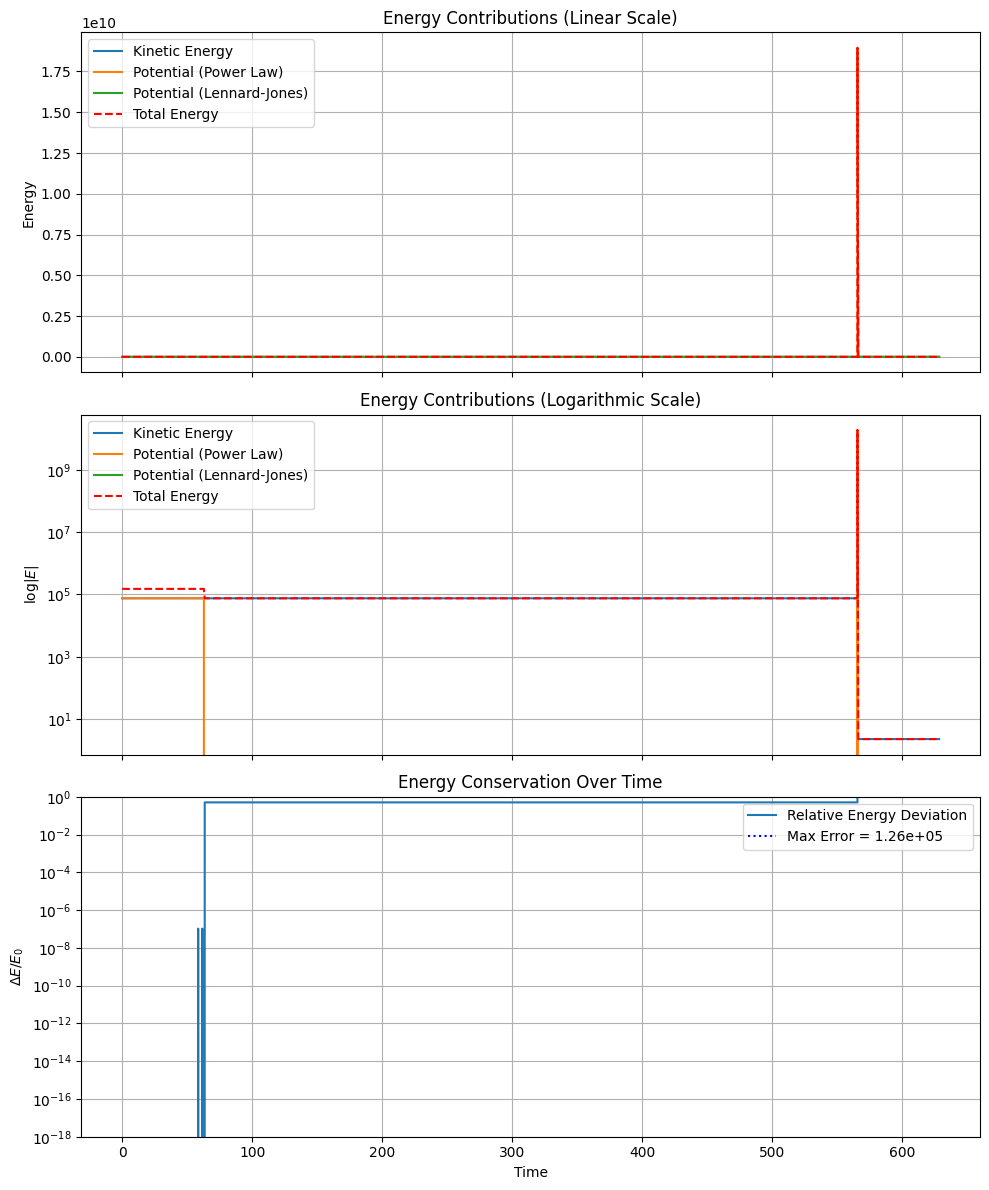


Erstelle kombinierten Temperatur-Plot...


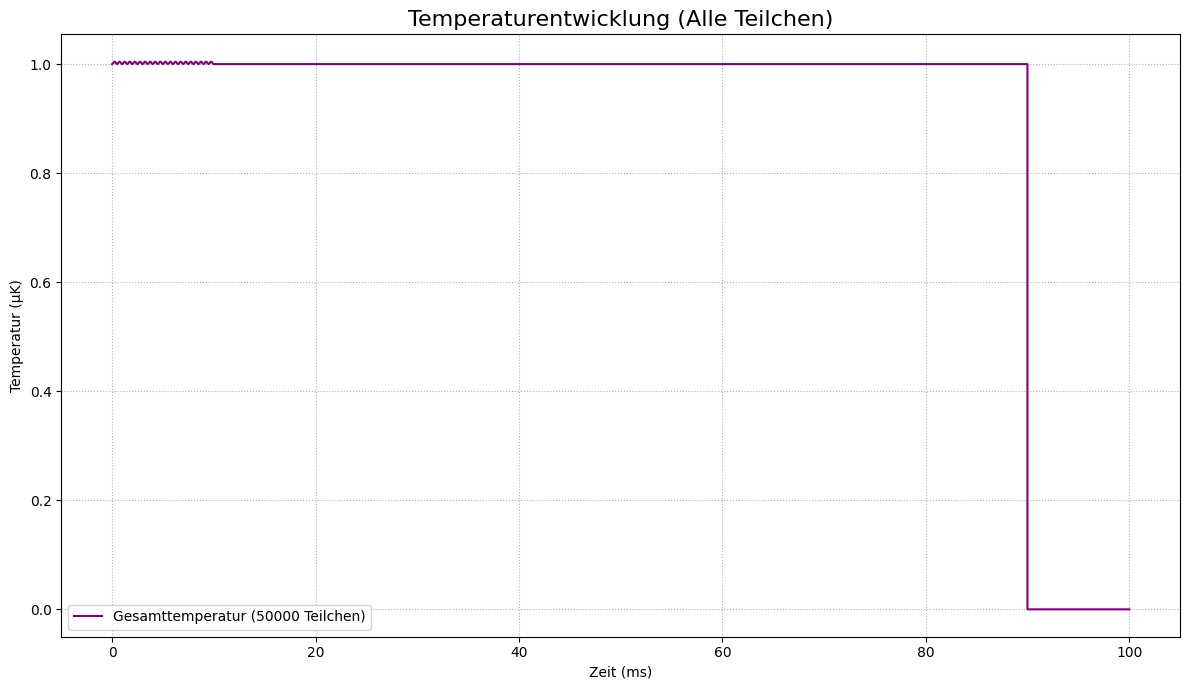

In [13]:
# --- PARAMETER ---
timestep_s = 1e-4
substeps = 100
n_particles = 50000
T = 1e-6

# --- Simulationszeiten ---
simulation_time_s__phase1 = 0.01  # 10 ms (Fangen)
simulation_time_s__phase2 = 0.08  # 50 ms (Freie Expansion 1)
simulation_time_s__phase3 = 200e-9 # 200 ns (Kick)
simulation_time_s__phase4 = 0.01  # 10 ms (Freie Expansion 2 zur Beobachtung)


r0_phys,C_phys = calculate_interaction_strength(10)
print(f"Interaktionsparameter: r0={r0_phys:.2e}, C={C_phys:.2e}")

# ===================================================================
# --- ERSTER SCHRITT: FALLE AN (Phase 1) ---
# ===================================================================
print("Starte Phase 1: Fangen...")
initial_state_params_phase1 = initialize_one_temp_gaussian_state(
    n_particles=n_particles, temp_k=T, omega_phys_hz=trap_frequencies_Hz,
    t_end_s=simulation_time_s__phase1, dt_s=timestep_s,
    r0_phys=r0_phys, C_phys=C_phys, precision=dtype, device=device
)
trap_params_dict_phase1 = {
    "omega_matrix": initial_state_params_phase1['omega_matrix']
}
integrator_config_phase1 = {
    "trap_force_func": harmonic_fp,
    "trap_force_params": trap_params_dict_phase1,
    "pair_force_func": no_pair_force_fp, "substeps": substeps
}
simulation_input_args_phase1 = {**initial_state_params_phase1, **integrator_config_phase1}
simulation_results_phase1 = run_verlet_simulation_general(**simulation_input_args_phase1, silent=False) # Silent-Modus
print("Phase 1 abgeschlossen.")

# ===================================================================
# --- ZWEITER SCHRITT: FREIE EXPANSION (Phase 2) ---
# ===================================================================
print("Starte Phase 2: Freie Expansion...")
initial_state_params_phase2 = initialize_one_temp_gaussian_state(
    n_particles=n_particles, temp_k=T, omega_phys_hz=trap_frequencies_Hz,
    t_end_s=simulation_time_s__phase2, dt_s=timestep_s,
    r0_phys=r0_phys, C_phys=C_phys, precision=dtype, device=device
)
initial_state_params_phase2['q0'] = simulation_results_phase1['positions'][-1]
initial_state_params_phase2['p0'] = simulation_results_phase1['momenta'][-1]
integrator_config_phase2 = {
    "trap_force_func": no_force_fp, "trap_force_params": {},
    "pair_force_func": no_pair_force_fp, "substeps": substeps
}
simulation_input_args_phase2 = {**initial_state_params_phase2, **integrator_config_phase2}
simulation_input_args_phase2.pop('omega_matrix', None)
simulation_results_phase2 = run_verlet_simulation_general(**simulation_input_args_phase2, silent=False)
print("Phase 2 abgeschlossen.")

# ===================================================================
# --- DRITTER SCHRITT: DELTA-KICK (Phase 3) ---
# ===================================================================
print("Starte Phase 3: Delta-Kick...")
timestep_s_phase3 = 1e-9 # Nur ein Schritt für den Kick
trap_frequencies_Hz_kick = (1583.0, 1583.0, 1583.0)
initial_state_params_phase3 = initialize_one_temp_gaussian_state(
    n_particles=n_particles, temp_k=T, omega_phys_hz=trap_frequencies_Hz_kick,
    t_end_s=simulation_time_s__phase3, dt_s=timestep_s_phase3, # Zeitachse für Phase 3
    r0_phys=r0_phys, C_phys=C_phys, precision=dtype, device=device
)
initial_state_params_phase3['q0'] = simulation_results_phase2['positions'][-1]
initial_state_params_phase3['p0'] = simulation_results_phase2['momenta'][-1]
trap_params_dict_phase3 = {
    "omega_matrix": initial_state_params_phase3['omega_matrix'] # Ursprüngliche Matrix
}
integrator_config_phase3 = {
    "trap_force_func": harmonic_fp,
    "trap_force_params": trap_params_dict_phase3,
    "pair_force_func": no_pair_force_fp, "substeps": substeps
}
simulation_input_args_phase3 = {**initial_state_params_phase3, **integrator_config_phase3}
simulation_results_phase3 = run_verlet_simulation_general(**simulation_input_args_phase3, silent=False)
print("Phase 3 (Kick) abgeschlossen.")

# ===================================================================
# --- NEU: VIERTER SCHRITT: BEOBACHTUNG (Phase 4) ---
# ===================================================================
print("Starte Phase 4: Beobachtung (Freie Expansion)...")
initial_state_params_phase4 = initialize_one_temp_gaussian_state(
    n_particles=n_particles, temp_k=T, omega_phys_hz=trap_frequencies_Hz,
    t_end_s=simulation_time_s__phase4, dt_s=timestep_s, # Normale Schrittweite
    r0_phys=r0_phys, C_phys=C_phys, precision=dtype, device=device
)
# Start von Phase 4 ist das Ende von Phase 3
initial_state_params_phase4['q0'] = simulation_results_phase3['positions'][-1]
initial_state_params_phase4['p0'] = simulation_results_phase3['momenta'][-1]

trap_params_dict_phase4 = {
    "omega_matrix": initial_state_params_phase1['omega_matrix'] # Ursprüngliche Matrix
}
integrator_config_phase4 = {
    "trap_force_func": no_force_fp,
    "trap_force_params": trap_params_dict_phase4,
    "pair_force_func": no_pair_force_fp, "substeps": substeps
}
simulation_input_args_phase4 = {**initial_state_params_phase4, **integrator_config_phase4}
simulation_input_args_phase4.pop('omega_matrix', None)
simulation_results_phase4 = run_verlet_simulation_general(**simulation_input_args_phase4, silent=False)
print("Phase 4 abgeschlossen.")


# --- ERGEBNISSE ALLER 4 PHASEN KOMBINIEREN ---
res1 = simulation_results_phase1
res2 = simulation_results_phase2
res3 = simulation_results_phase3
res4 = simulation_results_phase4

# 1. Zeitachse korrigieren
end_time_p1 = res1['times'][-1]
end_time_p2 = res2['times'][-1] + end_time_p1
end_time_p3 = res3['times'][-1] + end_time_p2

combined_times = torch.cat((
    res1['times'],
    res2['times'][1:] + end_time_p1,
    res3['times'][1:] + end_time_p2,
    res4['times'][1:] + end_time_p3
))

# 2. Kinetische Energie kombinieren
combined_kinetic = torch.cat((
    res1['kinetic_energy'],
    res2['kinetic_energy'][1:],
    res3['kinetic_energy'][1:],
    res4['kinetic_energy'][1:]
))

# 3. Potentielle Energie (Falle) kombinieren
combined_pot_trap = torch.cat((
    res1['potential_energy_trap'],
    res2['potential_energy_trap'][1:],
    res3['potential_energy_trap'][1:],
    res4['potential_energy_trap'][1:]
))

# 4. Potentielle Energie (Wechselwirkung) kombinieren
combined_pot_pair = torch.cat((
    res1['potential_energy_pair'],
    res2['potential_energy_pair'][1:],
    res3['potential_energy_pair'][1:],
    res4['potential_energy_pair'][1:]
))

# --- KOMBINIERTEN PLOT-AUFRUF ---
print("\nErstelle kombinierten Plot für alle 4 Phasen...")
plot_energy_and_error(
    combined_times,
    combined_kinetic,
    combined_pot_trap,
    combined_pot_pair
)
# 1. Zeitachse korrigieren (haben Sie schon für den Energie-Plot)
end_time_p1 = res1['times'][-1]
end_time_p2 = res2['times'][-1] + end_time_p1
end_time_p3 = res3['times'][-1] + end_time_p2


# 2. Impuls-Tensoren (Momenta) kombinieren
combined_momenta = torch.cat((
    res1['momenta'],
    res2['momenta'][1:],
    res3['momenta'][1:],
    res4['momenta'][1:]
))

# 3. Ein neues Ergebnis-Dictionary für die Plot-Funktion erstellen
combined_results_for_temp_plot = {
    "times": combined_times,
    "momenta": combined_momenta
}

# 4. Die neuen Plot-Funktion aufrufen
print("\nErstelle kombinierten Temperatur-Plot...")

# Wir holen T_ref und T0_s aus den Parametern von Phase 1
T0_s_scaling = initial_state_params_phase1['T0_s']

plot_temperature_evolution(
    results_dict=combined_results_for_temp_plot,
    n_particles=n_particles,
    T_ref=T,
    T0_s=initial_state_params_phase1['T0_s']
)